## Analisis cuantitativo de grupos economicos 

En este notebook se lleva a cabo un análisis cuantitativo de los grupos económicos, definidos según criterio experto. El objetivo es examinar diversas características de estos grupos, tanto categóricas como cuantitativas. Entre estas características se incluye, por ejemplo, la relación entre el patrimonio y el número de trabajadores. Este análisis proporcionará una visión integral del comportamiento de los grupos económicos en función de dichas variables.

### Se crea sesion de Spark

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import matplotlib.pyplot as plt
from pyspark.sql.functions import expr

In [18]:
spark = SparkSession.builder \
  .appName("Test")  \
  .config("spark.kerberos.access.hadoopFileSystems","abfs://data@datalakesii.dfs.core.windows.net/") \
  .config("spark.executor.memory", "16g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.executor.cores", "2") \
  .config("spark.driver.maxResultSize", "12g") \
  .getOrCreate()
warnings.filterwarnings('ignore', category=DeprecationWarning)
sc=spark.sparkContext
sc.setLogLevel ('ERROR')
spark.conf.set("spark.sql.parquet.int96RebaseModeInRead", "CORRECTED")
spark.conf.set("spark.sql.parquet.enableVectorizedReader","false")
spark.conf.set("spark.sql.parquet.int96RebaseModeInRead", "CORRECTED")
spark.conf.set("spark.sql.parquet.int96RebaseModeInWrite", "CORRECTED")
spark.conf.set("spark.sql.parquet.datetimeRebaseModeInRead", "CORRECTED")
spark.conf.set("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED")

### Datos de grupos economicos conocidos

Obtenemos la data de los grupos economicos conocidos desde el datalake.

In [19]:
spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatosOrigen/LibSDF/GE_APIUX_ARFI_E").createOrReplaceTempView("grupos_conocidos")
spark.sql('select PARU_RUT_E,COM, count(*) as c from grupos_conocidos group by PARU_RUT_E, COM order by PARU_RUT_E asc').createOrReplaceTempView("grupos_conocidos")
spark.sql('select PARU_RUT_E as CONT_RUT,COM from grupos_conocidos  order by PARU_RUT_E asc').createOrReplaceTempView("grupos_conocidos")
grupos_conocidos=spark.sql('select * from grupos_conocidos')

In [ ]:
spark.sql('select count(*) from grupos_conocidos').show()

Vemos que las sociedades de los grupos definidos son 18475

### Caracteristicas a analizar


Lo que se hara es realizar un analisis estadistico de las siguientes variables y su correspondiente fuentes:

- Familiaridad (libsdf.rel_familiares_aari_e)
- Oscuridad 
- Contadores: (libsdf. arfi_contadores_e) 
- Direcciones (dw. dw_trn_direcciones_e)
- Correos (dw. dw_trn_contribuyentes_e)
- Patrimonio (libsdf. patrimonio_at2021_eh)
- Rubro y sub Rubro (dw.dw_trn_actividad_economica_e y dw.dw_dim_actividad_economica_e)
- Directores (dw. dw_trn_djr_f1879_e) filtrar por F1879_RETE_DIRE10 > 0 OR F1879_RETE_DIRE20 >0
- Trabajadores (dw. dw_trn_djr_f1879_e y dw. dw_trn_djr_f1887_e)
- Lugares de Venta (dwbgdata. header_dte_consolidada_sas_nom)

### Agregacion de familiaridad 

Agregaremos la familiaridad ya calculada en el proyecto 1 de materia oscura tributaria. Este valor indica el porcentaje de familiares que se encuentra en el pool de personas naturales que esta liada a esa sociedad a traves de la malla societaria.

In [ ]:
familiaridad=spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/Oscuridad/final/familiaridad")
familiaridad.createOrReplaceTempView("familiaridad")
familiaridad=spark.sql('select CONT_RUT,COM,TASA_FAMILIARIDAD from  grupos_conocidos left join familiaridad on grupos_conocidos.CONT_RUT=familiaridad.RUT_SOCIEDAD where familiaridad.RUT_SOCIEDAD is not null')

# Contar la cantidad de valores distintos en la columna CONT_RUT
distinct_count = familiaridad.select('CONT_RUT').distinct().count()
print("Cantidad de valores con familiaridad conocida:", distinct_count)
familiaridad=familiaridad.toPandas()

In [ ]:
# Gráfico de distribución de TASA_FAMILIARIDAD
plt.figure(figsize=(10, 6))
sns.histplot(data=familiaridad, x='TASA_FAMILIARIDAD', bins=30, kde=True)
plt.title('Distribución de TASA_FAMILIARIDAD')
plt.xlabel('TASA_FAMILIARIDAD')
plt.ylabel('Frecuencia')
plt.show()

# Obtener los 5 grupos COM más grandes
top_5_com = familiaridad['COM'].value_counts().nlargest(5).index

# Filtrar el DataFrame para incluir solo las filas correspondientes a los 5 grupos más grandes
df_top_5 = familiaridad[familiaridad['COM'].isin(top_5_com)]

# Gráfico de violín de TASA_FAMILIARIDAD para los 5 grupos COM más grandes
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_top_5, x='COM', y='TASA_FAMILIARIDAD')

# Agregar el tamaño de cada grupo como etiquetas en el gráfico
for i, com_size in enumerate(top_5_com):
    size = df_top_5[df_top_5['COM'] == com_size].shape[0]
    plt.text(i, df_top_5['TASA_FAMILIARIDAD'].max() + 0.1, f"N={size}", horizontalalignment='center')

plt.title('Distribución de TASA_FAMILIARIDAD para los 5 grupos COM más grandes')
plt.xlabel('COM')
plt.ylabel('TASA_FAMILIARIDAD')
plt.xticks(rotation=45)
plt.show()


# Calcular el valor promedio de TASA_FAMILIARIDAD para cada grupo COM
promedio_por_com = familiaridad.groupby('COM')['TASA_FAMILIARIDAD'].mean()

# Crear un histograma para mostrar la distribución de los promedios de TASA_FAMILIARIDAD por COM
plt.figure(figsize=(10, 6))
sns.histplot(promedio_por_com, bins=20, kde=True, color='skyblue')
plt.title('Distribución del promedio de TASA_FAMILIARIDAD por COM')
plt.xlabel('Promedio de TASA_FAMILIARIDAD')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()




- El primer grafico nos muestra la distribucion general (no asociada a un grupo) de la variable familiaridad, por lo cual se observa que la mayoria de sociedades tiene un valor bajo. Sin embargo, tambien hay valores en el rango 0 a 100, con algunos valores que se destacan del resto y que tienen un 100% de familiaridad.  

- El segundo grafico nos muestra la distribucion del valor de familiaridad para los 5 grupos mas grandes, se puede observar que en general, distribuyen en torno a cero.

- El tercer grafico muestra la distribucion de los promedios de familiaridad en cada grupo COM. Observamos un comportamiento similar al grafico 1, con valores promedio cercanos a cero en su mayoria.

### Agregacion de oscuridad

Se agrega la oscuridad, valor relacionado a la cantidad de informacion disponible para un contribuyente.

In [ ]:
oscuridad=spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/Oscuridad/final/oscuridad")
oscuridad.createOrReplaceTempView("oscuridad")
oscuridad=spark.sql('select grupos_conocidos.CONT_RUT,COM,Value as OSCURIDAD from grupos_conocidos left join oscuridad on grupos_conocidos.CONT_RUT=oscuridad.CONT_RUT where oscuridad.CONT_RUT is not null')

# Contar la cantidad de valores distintos en la columna CONT_RUT
distinct_count = oscuridad.select('CONT_RUT').distinct().count()
print("Cantidad de valores con oscuridad conocida:", distinct_count)

oscuridad=oscuridad.toPandas()

In [ ]:
# Gráfico de distribución de OSCURIDAD
plt.figure(figsize=(10, 6))
sns.histplot(data=oscuridad, x='OSCURIDAD', bins=30, kde=True)
plt.title('Distribución de OSCURIDAD')
plt.xlabel('OSCURIDAD')
plt.ylabel('Frecuencia')
plt.show()


# Obtener los 5 grupos COM más grandes
top_5_com = oscuridad['COM'].value_counts().nlargest(5).index

# Filtrar el DataFrame para incluir solo las filas correspondientes a los 5 grupos más grandes
df_top_5 = oscuridad[oscuridad['COM'].isin(top_5_com)]


# Gráfico de violín de TASA_FAMILIARIDAD para los 5 grupos COM más grandes
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_top_5, x='COM', y='OSCURIDAD')

# Agregar el tamaño de cada grupo como etiquetas en el gráfico
for i, com_size in enumerate(top_5_com):
    size = df_top_5[df_top_5['COM'] == com_size].shape[0]
    plt.text(i, df_top_5['OSCURIDAD'].max() + 0.1, f"N={size}", horizontalalignment='center')

plt.title('Distribución de OSCURIDAD para los 5 grupos COM más grandes')
plt.xlabel('COM')
plt.ylabel('OSCURIDAD')
plt.xticks(rotation=45)
plt.show()

# Calcular el valor promedio de OSCURIDAD para cada grupo COM
promedio_por_com = oscuridad.groupby('COM')['OSCURIDAD'].mean()

# Crear un histograma para mostrar la distribución de los promedios de OSCURIDAD por COM
plt.figure(figsize=(10, 6))
sns.histplot(promedio_por_com, bins=20, kde=True, color='skyblue')
plt.title('Distribución del promedio de OSCURIDAD por COM')
plt.xlabel('Promedio de OSCURIDAD')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

- En el primer grafico, podemos ver la distribucion general de la variable oscuridad. Obtenemos que la mayoria de valores esta en torno a un valor 0.25 

- En el segundo grafico, para los 5 grupos mas grandes, observamos que no hay una regularidad particular  en la distribucion de los valores, el promedio tiene a estar en torno a 0.25

- En el primer grafico, podemos ver la distribucion general de la variable oscuridad. Obtenemos que la mayoria de valores esta en torno a un valor entre 0.2 y 0.4, con muy pocos valores sobre y debajo ese rango.

### Agregacion de contadores

Se agregara data disponible de los contadores para cada sociedad (en caso de que la haya)

In [ ]:
spark.sql('select * from libsdf.arfi_contadores_e').createOrReplaceTempView("contadores")
contadores=spark.sql('select grupos_conocidos.CONT_RUT, COM, RUT_CONTADOR from grupos_conocidos left join contadores on grupos_conocidos.CONT_RUT=contadores.CONT_RUT where contadores.CONT_RUT is not null')

# Contar la cantidad de valores distintos en la columna CONT_RUT
distinct_count = contadores.select('CONT_RUT').distinct().count()
print("Cantidad de valores con contador conocido:", distinct_count)

contadores=contadores.toPandas()

In [ ]:
# Encontrar los 20 valores más repetidos en general en la columna RUT_CONTADOR
top_15_repetidos = contadores['RUT_CONTADOR'].value_counts().nlargest(20)

# Gráfico de barras de los 20 valores más repetidos en general
plt.figure(figsize=(12, 6))
sns.barplot(x=top_15_repetidos.index, y=top_15_repetidos.values)
plt.title('Top 15 valores más repetidos en general')
plt.xlabel('RUT_CONTADOR')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def calculate_mode(series):
    try:
        mode = series.mode().iloc[0]
    except IndexError:
        mode = None
    return mode

# Calcular las modas de RUT_CONTADOR para cada COM
modas_por_com = contadores.groupby('COM')['RUT_CONTADOR'].apply(calculate_mode)
# Filtrar las modas que no son nulas
modas_filtradas = modas_por_com.dropna()

# Seleccionar las 15 modas más frecuentes
top_20_modas = modas_filtradas.value_counts().nlargest(20)

# Crear un gráfico de barras para las 20 modas más frecuentes
plt.figure(figsize=(10, 6))
top_20_modas.plot(kind='bar', color='skyblue')
plt.title('Top 15 Modas de RUT_CONTADOR por COM')
plt.xlabel('RUT_CONTADOR')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- En el primer grafico, vemos que existen valores repetidos con frecuencias mayores a 50 para dos valores de rut de contadores. Tambien se observa que hay mas valores repetidos con frecuencia sobre 20.

- En el segundo grafico, se obtuvo la moda del contador para cada grupo. Luego se grafica la distribucion de las modas de cada grupo, y vemos que existe una repeticion de valores de estas modas donde incluso tenemos 10 grupos para los cuales la moda es la misma.

- Este comportamiento de repeticion de las modas puede deberse al hecho que la contabilidad se realiza por empresas externas (se podria aislar este efecto teniendo la data adecuada).


### Agregacion de direcciones

Se agregara la data de las direcciones (en particular la comuna) para los contribuyentes en caso de haber informacion.

In [ ]:
spark.sql('select CONT_RUT,DIRE_COD_COMUNA_VO from dw.dw_trn_direcciones_e').createOrReplaceTempView("direccion")
spark.sql('select grupos_conocidos.CONT_RUT,COM, DIRE_COD_COMUNA_VO from grupos_conocidos left join direccion on grupos_conocidos.CONT_RUT=direccion.CONT_RUT').createOrReplaceTempView("grupos_aux")
spark.sql('select * from dw.dim_comuna').createOrReplaceTempView("dim_comuna")

direccion=spark.sql('select CONT_RUT, COM,COMU_DES_COMUNA as COMUNA from grupos_aux left join dim_comuna on grupos_aux.DIRE_COD_COMUNA_VO=dim_comuna.COMU_COD_COMUNA where dim_comuna.COMU_COD_COMUNA is not null')

# Contar la cantidad de valores distintos en la columna CONT_RUT
distinct_count = direccion.select('CONT_RUT').distinct().count()
print("Cantidad de valores con direccion conocida:", distinct_count)

direccion=direccion.toPandas()

In [ ]:
# Encontrar los 15 valores más repetidos en general en la columna COMUNA
top_15_repetidos_comuna = direccion['COMUNA'].value_counts().nlargest(15)

# Gráfico de barras de los 15 valores más repetidos en general
plt.figure(figsize=(12, 6))
sns.barplot(x=top_15_repetidos_comuna.index, y=top_15_repetidos_comuna.values)
plt.title('Top 15 valores más repetidos en general en COMUNA')
plt.xlabel('COMUNA')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def calculate_mode(series):
    try:
        mode = series.mode().iloc[0]
    except IndexError:
        mode = None
    return mode

# Calcular las modas de COMUNA para cada COM
modas_por_com = direccion.groupby('COM')['COMUNA'].apply(calculate_mode)
# Filtrar las modas que no son nulas
modas_filtradas = modas_por_com.dropna()

# Seleccionar las 15 modas más frecuentes
top_15_modas = modas_filtradas.value_counts().nlargest(15)

# Crear un gráfico de barras para las 15 modas más frecuentes
plt.figure(figsize=(10, 6))
top_15_modas.plot(kind='bar', color='skyblue')
plt.title('Top 15 Modas de COMUNA por COM')
plt.xlabel('COMUNA')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Del primer grafico, se puede observar que en general, la mayor cantidad de comunas asociadas son Las Condes, Santiago y Providencia.

- Del segundo grafico, obteniendo la moda de la comuna asociada a la direccion de cada grupo, se puede obtener que se acentua la distribucion. Los valores mas repetidos para las comunidades en direccion siguen siendo Las Condes, Providencia y Santiago. Hay otras comunas de Santiago presentes, como tambien de la zona norte y sur del pais.

### Agregacion de mails

Se hace el cruce con los mails asociados a los contribuyentes

In [ ]:
spark.sql('select * from dw.dw_trn_contribuyentes_e').schema

In [ ]:
spark.sql('select * from dw.dw_trn_contribuyentes_e').createOrReplaceTempView("mails")
mails=spark.sql('select grupos_conocidos.CONT_RUT, COM, CONT_E_MAIL_VO as MAIL from grupos_conocidos left join mails on grupos_conocidos.CONT_RUT=mails.CONT_RUT where mails.CONT_RUT is not null')

# Contar la cantidad de valores distintos en la columna CONT_RUT
distinct_count = mails.select('CONT_RUT').distinct().count()
print("Cantidad de valores con mails conocidos:", distinct_count)

mails=mails.toPandas()

In [ ]:
# Encontrar los 15 valores más repetidos en general en la columna MAILS
top_15_repetidos_mails = mails['MAIL'].value_counts().nlargest(15)

# Gráfico de barras de los 15 valores más repetidos en general
plt.figure(figsize=(12, 6))
sns.barplot(x=top_15_repetidos_mails.index, y=top_15_repetidos_mails.values)
plt.title('Top 15 valores más repetidos en general en MAIL')
plt.xlabel('MAIL')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def calculate_mode(series):
    try:
        mode = series.mode().iloc[0]
    except IndexError:
        mode = None
    return mode

# Calcular las modas de MAILS para cada COM
modas_por_com = mails.groupby('COM')['MAIL'].apply(calculate_mode)
# Filtrar las modas que no son nulas
modas_filtradas = modas_por_com.dropna()

# Seleccionar las 20 modas más frecuentes
top_20_modas = modas_filtradas.value_counts().nlargest(20)

# Crear un gráfico de barras para las 20 modas más frecuentes
plt.figure(figsize=(10, 6))
top_20_modas.plot(kind='bar', color='skyblue')
plt.title('Top 15 Modas de MAIL por COM')
plt.xlabel('MAIL')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


- En el primer grafico, se observa la distribucion de las direcciones de correo electronico de los contribuyentes, donde podemos observar repeticiones, incluso superando una frecuencia de 50.

- En el segundo grafico, se tiene la moda de la direccion de correo electronico para cada grupo en distribucion, se puede observar que no existe una gran cantidad repeticiones de la modas de cada grupo, al contrario del primer graficos de data no agregada.

### Agregacion de patrimonios

Se lee la data de los patrimonios del archivo luego de la propagacion del patrimonio desde personas naturales a sociedades por medio de la malla societaria. El patrimonio se obtuvo desde dos fuentes.

In [ ]:
spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/Agrupacion_empresas_similares/patrimonio/patrimonios_completos").createOrReplaceTempView("pat_2022")

In [ ]:
spark.sql('select grupos_conocidos.CONT_RUT,pat_2022.CONT_RUT,COM,Value as PATRIMONIO_222  from grupos_conocidos left join pat_2022 on grupos_conocidos.CONT_RUT=pat_2022.CONT_RUT where pat_2022.CONT_RUT is not null').createOrReplaceTempView("pat_grupos")

In [ ]:
spark.sql("select count(*) from pat_grupos").show()
#Vemos que al usar los patrinomios completos(todos sus socios tienen patrimonio conocido) tenemos 4615 sociedades
#de los grupos economicos con patrimonio conocido. 

Que es el numero de contribuyentes de los grupos economicos con patrimonio de socios completamente calculado. Comparemos con todos los patrimonios, incluso incompletos:

In [ ]:
spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/Agrupacion_empresas_similares/patrimonio/patrimonios_incompletos").createOrReplaceTempView("pat_2022_incompleto")
spark.sql('select  RUT_SOCIEDAD as CONT_RUT, SUM(PAT_2022) as PAT_2022 from pat_2022_incompleto group by RUT_SOCIEDAD').createOrReplaceTempView("pat_2022_incompleto")
spark.sql('select * from pat_2022_incompleto where PAT_2022 is not null').createOrReplaceTempView("pat_2022_incompleto")

In [ ]:
spark.sql('select grupos_conocidos.CONT_RUT,pat_2022_incompleto.PAT_2022,COM from grupos_conocidos left join pat_2022_incompleto on grupos_conocidos.CONT_RUT=pat_2022_incompleto.CONT_RUT where pat_2022_incompleto.CONT_RUT is not null').createOrReplaceTempView("pat_grupos_incompletos")
spark.sql("select count(*) from pat_grupos_incompletos").show()

#Cuando usamos la data con todos los patrimonios encontrados (incluso con los que no tienen todos sus socios con patrimonio conocido)
# obtenemos 8364 sociedades de los grupos economicos. Usaremos esta data para la estadistica general.

Que es el valor de cruce de sociedades de grupos economicos con todos los patrimonios, completos e incompletos. 

In [ ]:
spark.sql("select * from pat_grupos_incompletos").show()

Veamos el numero de sociedades sobre cierto umbral

In [ ]:
#Veamos cuantos valores sobre 8 mil millones de pesos en patrimonio hay
spark.sql("select * from pat_grupos_incompletos where PAT_2022>8000000000 order by PAT_2022 desc").show()
spark.sql("select count(*) from pat_grupos_incompletos where PAT_2022>8000000000").show()

Por lo que tenemos 529 sociedades con patrimonio sobre 8 mil millones de pesos.

In [ ]:
spark.sql("select * from pat_grupos_incompletos order by PAT_2022 desc").show()

### Distribucion de patrimonios de sociedades incluyendo datos faltantes (patrimonio sesgado) y sin outliers

In [ ]:
#Calcularemos la distribucion de los valores de patrimonio en general, incluyendo socios faltantes
df_pandas=spark.sql("select * from pat_grupos_incompletos").toPandas()

# Calcular el primer y tercer cuartil
q1 = df_pandas['PAT_2022'].quantile(0.25)
q3 = df_pandas['PAT_2022'].quantile(0.75)

# Calcular el rango intercuartil (IQR)
iqr = q3 - q1

# Calcular los límites inferior y superior del rango intercuartil
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar el DataFrame para mantener solo los valores dentro del rango intercuartil
filtered_df = df_pandas[(df_pandas['PAT_2022'] >= lower_bound) & (df_pandas['PAT_2022'] <= upper_bound)]

# Crear el histograma con 20 bines para los datos filtrados
plt.hist(filtered_df['PAT_2022'], bins=20, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('PAT_2022')
plt.ylabel('Frecuencia')
plt.title('Histograma de Distribución de PAT_2022 (sin outliers)')

# Mostrar el histograma
plt.show()



### Distribucion de patrimonios totales de grupos de sociedades incluyendo datos faltantes (patrimonio sesgado) y sin outliers

In [ ]:
spark.sql("select COM, sum(PAT_2022) as SUM_PAT from pat_grupos_incompletos GROUP BY COM").createOrReplaceTempView("aux")
spark.sql("select * from aux where SUM_PAT>2.5E10").show()
spark.sql("select count(*) from aux where SUM_PAT>2.5E10").show()
#

Tenemos 209 grupos donde la suma de los patrimonios es mayor a 2.5*10^10 pesos. Veamos lo que muestra la distribucion de totales por grupo.

In [ ]:
df_pandas=spark.sql("select COM, sum(PAT_2022) as SUM_PAT from pat_grupos_incompletos GROUP BY COM").toPandas()

# veamos la suma de los patrimonions de cada grupo
# Calcular el primer y tercer cuartil
q1 = df_pandas['SUM_PAT'].quantile(0.25)
q3 = df_pandas['SUM_PAT'].quantile(0.75)

# Calcular el rango intercuartil (IQR)
iqr = q3 - q1

# Calcular los límites inferior y superior del rango intercuartil
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar el DataFrame para mantener solo los valores dentro del rango intercuartil
filtered_df = df_pandas[(df_pandas['SUM_PAT'] >= lower_bound) & (df_pandas['SUM_PAT'] <= upper_bound)]

# Crear el histograma con 20 bines para los datos filtrados
plt.hist(filtered_df['SUM_PAT'], bins=20, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('SUM_PAT')
plt.ylabel('Frecuencia')
plt.title('Histograma de Distribución de SUM_PAT (sin outliers)')

# Mostrar el histograma
plt.show()


Podemos observar que la mayoria de valores de total de patrimonio por comunidad estan bajo los 2.5 10e10 pesos.Los valores outliers se presentan en la seccion anterior.

### Agregacion de rubros asociados

In [ ]:
spark.sql('select * from dw.dw_trn_actividad_economica_e').createOrReplaceTempView("acteco")


Primero se hace el cruce con la tabla de actividad economica y luego con la tabla con la descripcion de esos rubros.

In [ ]:
spark.sql('select grupos_conocidos.CONT_RUT, COM,ACTECO_COD_ACTECO from grupos_conocidos left join acteco on grupos_conocidos.CONT_RUT=acteco.CONT_RUT where acteco.CONT_RUT is not null').createOrReplaceTempView("grupos_conocidos_auxiliar")

In [ ]:
spark.sql('select * from dw.dw_dim_actividad_economica_e').createOrReplaceTempView("acteco_aux")

In [ ]:
acteco=spark.sql('select grupos_conocidos_auxiliar.CONT_RUT, COM, ACEC_DES_ACTECO,ACEC_DES_SUBRUBRO, ACEC_DES_RUBRO  from grupos_conocidos_auxiliar left join acteco_aux on grupos_conocidos_auxiliar.ACTECO_COD_ACTECO=acteco_aux.ACEC_COD_ACTECO where acteco_aux.ACEC_COD_ACTECO is not null')
# Contar la cantidad de valores distintos en la columna CONT_RUT
distinct_count = acteco.select('CONT_RUT').distinct().count()
print("Cantidad de valores con actividad economica conocida:", distinct_count)

acteco=acteco.toPandas()


In [ ]:
# Encontrar los 15 valores más repetidos en general en la columna ACEC_DES_SUBRUBRO
top_15_repetidos_subrubro = acteco['ACEC_DES_SUBRUBRO'].value_counts().nlargest(15)

# Gráfico de barras horizontales de los 15 valores más repetidos en general
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_repetidos_subrubro.values, y=top_15_repetidos_subrubro.index, orient='h')
plt.title('Top 15 valores más repetidos en general en ACEC_DES_SUBRUBRO')
plt.xlabel('Frecuencia')
plt.ylabel('ACEC_DES_SUBRUBRO')
plt.tight_layout()
plt.show()

# Calcular las modas de ACEC_DES_SUBRUBRO para cada COM
modas_subrubro_por_com = acteco.groupby('COM')['ACEC_DES_SUBRUBRO'].apply(calculate_mode)
# Filtrar las modas que no son nulas
modas_subrubro_filtradas = modas_subrubro_por_com.dropna()

# Seleccionar las 15 modas más frecuentes
top_15_modas_subrubro = modas_subrubro_filtradas.value_counts().nlargest(15)

# Crear un gráfico de barras horizontales para las 15 modas más frecuentes de ACEC_DES_SUBRUBRO
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_modas_subrubro.values, y=top_15_modas_subrubro.index, orient='h', palette='viridis')
plt.title('Top 15 Modas de ACEC_DES_SUBRUBRO por COM')
plt.xlabel('Frecuencia')
plt.ylabel('ACEC_DES_SUBRUBRO')
plt.tight_layout()
plt.show()


- En el primer grafico, obtenemos los valores mas repetidos del subrubro, estas son fondos de sociedades de inversion, consultorias, inmobiliarias y servicios financieros.

- En el segundo grafico, se grafican las modas de los grupos economicos en cuanto a subrubro, nuevamente tenemos fondos de sociedades de inversion, consultorias, inmobiliarias y servicios financieros.

In [ ]:
# Encontrar los 15 valores más repetidos en general en la columna ACEC_DES_RUBRO
top_15_repetidos_rubro = acteco['ACEC_DES_RUBRO'].value_counts().nlargest(15)

# Gráfico de barras horizontales de los 15 valores más repetidos en general
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_repetidos_rubro.values, y=top_15_repetidos_rubro.index, orient='h')
plt.title('Top 15 valores más repetidos en general en ACEC_DES_RUBRO')
plt.xlabel('Frecuencia')
plt.ylabel('ACEC_DES_RUBRO')
plt.tight_layout()
plt.show()

# Calcular las modas de ACEC_DES_RUBRO para cada COM
modas_rubro_por_com = acteco.groupby('COM')['ACEC_DES_RUBRO'].apply(calculate_mode)
# Filtrar las modas que no son nulas
modas_rubro_filtradas = modas_rubro_por_com.dropna()

# Seleccionar las 15 modas más frecuentes
top_15_modas_rubro = modas_rubro_filtradas.value_counts().nlargest(15)

# Crear un gráfico de barras horizontales para las 15 modas más frecuentes de ACEC_DES_RUBRO
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_modas_rubro.values, y=top_15_modas_rubro.index, orient='h', palette='viridis')
plt.title('Top 15 Modas de ACEC_DES_RUBRO por COM')
plt.xlabel('Frecuencia')
plt.ylabel('ACEC_DES_RUBRO')
plt.tight_layout()
plt.show()


- En el caso del rubro y sin agregar en moda pr comunidad, los valores mas repetidos son de actividades financieras y seguros, actividades profesionales, cientificas y tecnicas, comercio y reparacion de vehiculos.

- Para las modas de los grupos, el patron se repite.

### Directores 

Se lee la data que contiene los ruts informados de honorarios de directores

In [ ]:
a=spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatosOrigen/DW/DW_TRN_DJR_F1879_E/part-00001-51ac1a73-cc1a-42c0-9a32-f42e184500f2-c000.snappy.parquet")

In [ ]:
a.printSchema()

In [ ]:
s10=a.filter(a.F1879_RETE_DIRE10.isNotNull()).filter(a.F1879_RETE_DIRE10>0)
s20=a.filter(a.F1879_RETE_DIRE20.isNotNull()).filter(a.F1879_RETE_DIRE20>0)

In [ ]:
# Seleccionar solo las columnas CONT_RUT y CONT_RUT_INFO de s10
s10_selected = s10.select("CONT_RUT", "CONT_RUT_INFO")
s10_selected = s10_selected.withColumnRenamed("CONT_RUT", "CONT_RUT2")

# Seleccionar solo las columnas CONT_RUT y CONT_RUT_INFO de s20
s20_selected = s20.select("CONT_RUT", "CONT_RUT_INFO")
s20_selected = s20_selected.withColumnRenamed("CONT_RUT", "CONT_RUT2")

In [ ]:
# Unir los DataFrames s10_selected y s20_selected
union_df = s10_selected.union(s20_selected)

# Eliminar las filas duplicadas
unique_df = union_df.dropDuplicates()

# Mostrar el DataFrame resultante
unique_df.show()

In [ ]:
joined_df = grupos_conocidos.join(unique_df, unique_df.CONT_RUT2 == grupos_conocidos.CONT_RUT, "left")


In [ ]:
# Filtrar las filas donde la columna COM no sea nula
coincidencias_df = joined_df.filter(unique_df.CONT_RUT2.isNotNull())
# Eliminar la segunda columna de cont_rut (asumiendo que se llama "CONT_RUT_2")
coincidencias_df = coincidencias_df.drop("CONT_RUT2")
# Mostrar el DataFrame resultante
coincidencias_df.show()

In [ ]:
coincidencias_df.select("CONT_RUT").distinct().count()

In [ ]:
directores_df=coincidencias_df.toPandas()

In [ ]:
directores_df

In [ ]:

def calculate_mode(series):
    try:
        mode = series.mode().iloc[0]
    except IndexError:
        mode = None
    return mode


# Encontrar los 15 valores más repetidos en general en la columna CONT_RUT_INFO
top_15_repetidos_directores = directores_df['CONT_RUT_INFO'].value_counts().nlargest(15)

# Gráfico de barras horizontales de los 15 valores más repetidos en general
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_repetidos_directores.values, y=top_15_repetidos_directores.index, orient='h')
plt.title('Top 15 valores más repetidos en general en CONT_RUT_INFO')
plt.xlabel('Frecuencia')
plt.ylabel('CONT_RUT_INFO')
plt.tight_layout()
plt.show()

# Calcular las modas de CONT_RUT_INFO para cada COM
modas_directores_por_com = directores_df.groupby('COM')['CONT_RUT_INFO'].apply(calculate_mode)
# Filtrar las modas que no son nulas
modas_directores_filtradas = modas_directores_por_com.dropna()

# Seleccionar las 15 modas más frecuentes
top_15_modas_directores = modas_directores_filtradas.value_counts().nlargest(15)

# Crear un gráfico de barras horizontales para las 15 modas más frecuentes de CONT_RUT_INFO
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_modas_directores.values, y=top_15_modas_directores.index, orient='h', palette='viridis')
plt.title('Top 15 Modas de CONT_RUT_INFO por COM')
plt.xlabel('Frecuencia')
plt.ylabel('CONT_RUT_INFO')
plt.tight_layout()
plt.show()


- Del primero grafico, es posible observar que se repiten en todas las sociedades sin considerar comunidades, hay repeticiones de directores en estas sociedades,con frecuencias de repeticion menor a 8.

- En el segundo grafico, tambien se observa que hay grupos economicos cuyos directores mas frecuentes en el grupo se repiten en otros grupos una vez.

### Cantidad de trabajadores dependientes y honorarios

Para el analisis de trabajadores, tanto dependientes como a honorarios, utilizaremos la data procesada que se calcula en otro notebook mediante las declaraciones juradas del periodo correspondiente.

In [ ]:
workers=pd.read_csv('data/processed/trabajadores/trabajadores_last_declaration.csv', index_col=0 )

In [ ]:
# Realizar un inner join en la columna 'CONT_RUT' donde 'COM' no sea null
merged_df = grupos_conocidos.merge(workers, on='CONT_RUT', how='inner')

# Seleccionar las columnas de interés
columns_to_keep = ['CONT_RUT', 'COM', 'cantidad_trabajadores_honorarios', 'cantidad_trabajadores_dependientes']
final_workers = merged_df[columns_to_keep]

La cantidad de datos que se cruzaron

In [ ]:
len(final_workers)

### Cantidad de trabajadores dependientes con outliers

In [ ]:
# Gráfico de distribución de cantidad_trabajadores_dependientes
plt.figure(figsize=(10, 6))
sns.histplot(data=final_workers, x='cantidad_trabajadores_dependientes', bins=30, kde=True)
plt.title('Distribución de cantidad_trabajadores_dependientes')
plt.xlabel('cantidad_trabajadores_dependientes')
plt.ylabel('Frecuencia')
plt.show()

# Obtener los 5 grupos COM más grandes
top_5_com = final_workers['COM'].value_counts().nlargest(5).index

# Filtrar el DataFrame para incluir solo las filas correspondientes a los 5 grupos más grandes
df_top_5 = final_workers[final_workers['COM'].isin(top_5_com)]

# Gráfico de violín de cantidad_trabajadores_dependientes para los 5 grupos COM más grandes
plt.figure(figsize=(12, 8))
sns.violinplot(data=df_top_5, x='COM', y='cantidad_trabajadores_dependientes')
plt.title('Distribución de cantidad_trabajadores_dependientes para los 5 grupos COM más grandes')
plt.xlabel('COM')
plt.ylabel('cantidad_trabajadores_dependientes')
plt.xticks(rotation=45)

# Agregar texto con el tamaño de las comunidades más grandes
for i, com in enumerate(top_5_com):
    size = len(final_workers[final_workers['COM'] == com])
    plt.text(i, df_top_5['cantidad_trabajadores_dependientes'].max() + 1, f"{com} (N={size})", ha='center')

plt.tight_layout()
plt.show()

# Calcular el valor promedio de cantidad_trabajadores_dependientes para cada grupo COM
promedio_por_com = final_workers.groupby('COM')['cantidad_trabajadores_dependientes'].mean()

# Crear un histograma para mostrar la distribución de los promedios de cantidad_trabajadores_dependientes por COM
plt.figure(figsize=(10, 6))
sns.histplot(promedio_por_com, bins=10, kde=True, color='skyblue')
plt.title('Distribución del promedio de cantidad_trabajadores_dependientes por COM')
plt.xlabel('Promedio de cantidad_trabajadores_dependientes')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


- El primer grafico nos muestra la distribucion de la cantidad de trabajadores para todos los contribuyentes involucrados, el rango va de 0 a aproximadamente 35 mil, que corresponderia a empresas grandes.

- El segundo grafico nos muestra, para los cinco grupos mas grandes, nos muestra la distribucion de la cantidad de trabajadores dependientes. La distribucion es amplia, lo que nos sugiere filtrar los outliers para un analisis posterior.

- El tercer grafico muestra la distribucion del promedio de trabajadores dependientes para cada comunidad, obteniendose valores similares al grafico 1, por lo cual repetimos el analisis sin outliers.

### Cantidad de trabajadores dependientes sin  outliers

In [ ]:

# Función para identificar y filtrar outliers utilizando el método de IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df, len(outliers)

# Eliminar outliers de cantidad_trabajadores_dependientes y obtener el número de outliers
final_workers_filtered, num_outliers = remove_outliers(final_workers, 'cantidad_trabajadores_dependientes')

# Imprimir el número de outliers y el número de datos después de filtrar los outliers
print(f"Número de outliers eliminados: {num_outliers}")
print(f"Número de datos después de filtrar outliers: {final_workers_filtered.shape[0]}")

# Gráfico de distribución de cantidad_trabajadores_dependientes sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(data=final_workers_filtered, x='cantidad_trabajadores_dependientes', bins=30, kde=True)
plt.title('Distribución de cantidad_trabajadores_dependientes sin outliers')
plt.xlabel('cantidad_trabajadores_dependientes')
plt.ylabel('Frecuencia')
plt.show()



# Calcular el valor promedio de cantidad_trabajadores_dependientes para cada grupo COM sin outliers
promedio_por_com = final_workers_filtered.groupby('COM')['cantidad_trabajadores_dependientes'].mean()

# Crear un histograma para mostrar la distribución de los promedios de cantidad_trabajadores_dependientes por COM sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(promedio_por_com, bins=10, kde=True, color='skyblue')
plt.title('Distribución del promedio de cantidad_trabajadores_dependientes por COM sin outliers')
plt.xlabel('Promedio de cantidad_trabajadores_dependientes')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


- Se puede observar del primer grafico que grafica la distribucion de trabajadores dependientes tiende a valores bajos, se observa que una parte importante de las sociedades tiene menos de 150 trabajadores dependientes.
- Del segundo grafico, se observa una situacion similar, esta vez el promedio de trabajadores en general esta bajo 150.

### Cantidad de trabajadores independientes con outliers

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de distribución de cantidad_trabajadores_honorarios
plt.figure(figsize=(10, 6))
sns.histplot(data=final_workers, x='cantidad_trabajadores_honorarios', bins=30, kde=True)
plt.title('Distribución de cantidad_trabajadores_honorarios')
plt.xlabel('cantidad_trabajadores_honorarios')
plt.ylabel('Frecuencia')
plt.show()

# Obtener los 5 grupos COM más grandes
top_5_com = final_workers['COM'].value_counts().nlargest(5).index

# Filtrar el DataFrame para incluir solo las filas correspondientes a los 5 grupos más grandes
df_top_5 = final_workers[final_workers['COM'].isin(top_5_com)]

# Gráfico de violín de cantidad_trabajadores_honorarios para los 5 grupos COM más grandes
plt.figure(figsize=(12, 8))
sns.violinplot(data=df_top_5, x='COM', y='cantidad_trabajadores_honorarios')
plt.title('Distribución de cantidad_trabajadores_honorarios para los 5 grupos COM más grandes')
plt.xlabel('COM')
plt.ylabel('cantidad_trabajadores_honorarios')
plt.xticks(rotation=45)

# Agregar texto con el tamaño de las comunidades más grandes
for i, com in enumerate(top_5_com):
    size = len(final_workers[final_workers['COM'] == com])
    plt.text(i, df_top_5['cantidad_trabajadores_honorarios'].max() + 1, f"{com} (N={size})", ha='center')

plt.tight_layout()
plt.show()

# Calcular el valor promedio de cantidad_trabajadores_honorarios para cada grupo COM
promedio_por_com = final_workers.groupby('COM')['cantidad_trabajadores_honorarios'].mean()

# Crear un histograma para mostrar la distribución de los promedios de cantidad_trabajadores_honorarios por COM
plt.figure(figsize=(10, 6))
sns.histplot(promedio_por_com, bins=10, kde=True, color='skyblue')
plt.title('Distribución del promedio de cantidad_trabajadores_honorarios por COM')
plt.xlabel('Promedio de cantidad_trabajadores_honorarios')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


- Se observa el mismo comportamiento que habiamos visto en los graficos de trabajadores dependientes, avidenciado en el grafico 2, donde se muestra la distribucion de trabajadores para los 5 grupos mas grandes. Se observa una alta dispersion, lo que sugiere quitar los outliers y hacer un nuevo analisis.

### Cantidad de trabajadores independientes sin outliers

In [4]:

# Eliminar outliers de cantidad_trabajadores_honorarios y obtener el número de outliers
final_workers_filtered, num_outliers = remove_outliers(final_workers, 'cantidad_trabajadores_honorarios')

# Imprimir el número de outliers y el número de datos después de filtrar los outliers
print(f"Número de outliers eliminados: {num_outliers}")
print(f"Número de datos después de filtrar outliers: {final_workers_filtered.shape[0]}")

# Gráfico de distribución de cantidad_trabajadores_honorarios sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(data=final_workers_filtered, x='cantidad_trabajadores_honorarios', bins=30, kde=True)
plt.title('Distribución de cantidad_trabajadores_honorarios sin outliers')
plt.xlabel('cantidad_trabajadores_honorarios')
plt.ylabel('Frecuencia')
plt.show()



# Calcular el valor promedio de cantidad_trabajadores_honorarios para cada grupo COM sin outliers
promedio_por_com = final_workers_filtered.groupby('COM')['cantidad_trabajadores_honorarios'].mean()

# Crear un histograma para mostrar la distribución de los promedios de cantidad_trabajadores_honorarios por COM sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(promedio_por_com, bins=10, kde=True, color='skyblue')
plt.title('Distribución del promedio de cantidad_trabajadores_honorarios por COM sin outliers')
plt.xlabel('Promedio de cantidad_trabajadores_honorarios')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


NameError: name 'remove_outliers' is not defined

- Se puede observar, luego de retirar los outliers, en el primer grafico, que la gran mayoria de las sociedades tiene menos de 20 trabajadores independientes.
- En el segundo grafico,que muestra la distribucion de los promedios de los trabajadores independientes en cada grupo, que la mayoria de los grupos tienen menos de 20 trabajadores independientes. 

### Centros de venta

A continuacion se analizara si el contribyente vende hacia regiones extremas (norte  y sur) a partir de los documentos tributarios electronicos. 

In [20]:
spark.sql('select dhdr_rut_emisor, dhdr_cmna_origen from dwbgdata.header_dte_consolidada_enc_sas_analitica ').createOrReplaceTempView("documentos")
spark.sql('select dhdr_rut_emisor,COM,dhdr_cmna_origen from documentos left join grupos_conocidos on grupos_conocidos.cont_rut=documentos.dhdr_rut_emisor where COM is not null').createOrReplaceTempView("emitidos")
spark.sql('select * from libsdf.DICCIONARIO_CMNA_DTE_ARFI').createOrReplaceTempView("comunas")
spark.sql('select dhdr_rut_emisor,COM,comuna_obtenida from emitidos left join comunas on emitidos.dhdr_cmna_origen=comunas.dhdr_dir_origen').createOrReplaceTempView("puntos_venta")

Hive Session ID = cba5126b-32a8-4f91-9aa8-7b1b20ea3e6d


In [21]:
spark.sql('select dhdr_rut_emisor,COM, comuna_obtenida, count(*) as c  from puntos_venta where dhdr_rut_emisor is not null group by dhdr_rut_emisor,COM,comuna_obtenida').createOrReplaceTempView("puntos_venta")


In [22]:
spark.sql('select dhdr_rut_emisor, COM,REPLACE(comuna_obtenida,"�", "N") AS comuna_obtenida from puntos_venta').createOrReplaceTempView("puntos_venta")


In [23]:
spark.sql('select COMU_DES_COMUNA, COMU_DES_REGION from dw.dim_comuna').createOrReplaceTempView("comunas")

In [24]:
spark.sql('select  dhdr_rut_emisor,COM, comuna_obtenida,COMU_DES_COMUNA, COMU_DES_REGION from puntos_venta left join comunas on puntos_venta.comuna_obtenida=comunas.COMU_DES_COMUNA Where comuna_obtenida is not null and COMU_DES_COMUNA IS not  NULL').createOrReplaceTempView("puntos_venta_final")


In [25]:
df=spark.sql('select * from puntos_venta_final')

In [26]:
# Definir los patrones de las regiones extremas
# I region de Tarapaca
# XV reion de Arica y Parinacota
# XI regino de Aysen
#XII region de Magallanes

extreme_regions_norte = ["XV R", "I RE"]
extreme_regions_sur = ["XI R","XII "]

# Añadir una nueva columna con los primeros tres caracteres de la región
df = df.withColumn("region_prefix", substring(col("COMU_DES_REGION"), 1, 4))

# Clasificar las regiones
df = df.withColumn(
    "extremo_norte",
    when(col("region_prefix").isin(extreme_regions_norte), 1).otherwise(0)
)
df = df.withColumn(
    "extremo_sur",
    when(col("region_prefix").isin(extreme_regions_sur), 1).otherwise(0)
)



In [27]:
# Agrupar por dhdr_rut_emisor y calcular la suma de extremo_norte y extremo_sur
df_grouped = df.groupBy("dhdr_rut_emisor","COM").agg(
    sum("extremo_norte").alias("total_extremo_norte"),
    sum("extremo_sur").alias("total_extremo_sur")
)

# Crear una columna adicional que indique si distribuye al extremo norte y al extremo sur
df_final = df_grouped.withColumn(
    "distribuye_extremos",
    when((col("total_extremo_norte") > 0) & (col("total_extremo_sur") > 0), "si").otherwise("no")
)


In [28]:
df_final=df_final.toPandas()

In [ ]:
spark.stop()

In [ ]:
df_final

,dhdr_rut_emisor,COM,total_extremo_norte,total_extremo_sur,distribuye_extremos
0,Gq9Yil8BfFdgzQbcUDAG7w==,1699,1,0,no
1,SeTpFSKbXaLUfFxEboE5Lg==,3100,0,0,no
2,D7+t12BYU5svXrpZfOPJMQ==,948,0,0,no
3,bMBAuKtIeXNDrM6uJCXVsA==,2990,0,0,no
4,cdjQrzjIxdLy1eINImIZdA==,524,0,0,no
...,...,...,...,...,...
9885,9HQGZnjZ6ERYgLE5w4wW1w==,1534,0,0,no
9886,yLP6KOchLVnxTXJrwxzurg==,394,0,0,no
9887,iuMSj9OhR74brs7xSGhQQg==,937,0,0,no
9888,apJHGZDI09IdAJ2o5fqCjQ==,998,0,0,no


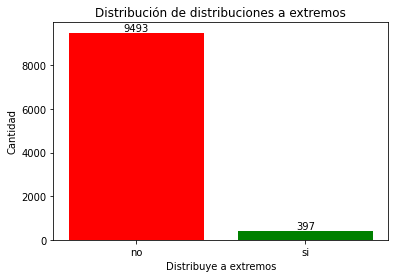

In [32]:
# Calcular los valores de 'distribuye_extremos'
extremos_counts = df_final['distribuye_extremos'].value_counts()
# Crear la gráfica de barras
plt.bar(extremos_counts.index, extremos_counts.values, color=['red', 'green'])

# Añadir etiquetas y título
plt.xlabel('Distribuye a extremos')
plt.ylabel('Cantidad')
plt.title('Distribución de distribuciones a extremos')

# Añadir etiquetas sobre las barras con el número correspondiente
for i, value in enumerate(extremos_counts.values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()

A partir del grafico anterior y analizando la informacion por cada contribuyente, se evidencia que la gran mayoria no distribuye hacia los extremos del pais, o bien hacia solo un extremo. Sin embargo, hay una cantidad menor de contribuyentes que si vende hacia los extremos norte y sur. 

In [1]:
spark.stop()

NameError: name 'spark' is not defined

In [34]:
# Agrupar por 'COM' y determinar si al menos un RUT distribuye a extremos
df_grouped = df_final.groupby('COM').agg({'distribuye_extremos': lambda x: 'si' if 'si' in x.values else 'no'}).reset_index()

# Renombrar la columna
df_grouped = df_grouped.rename(columns={'distribuye_extremos': 'distribuye_extremos_com'})

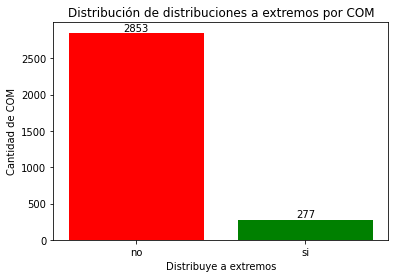

In [35]:
# Contar cuántos 'COM' distribuyen a extremos y cuántos no
extremos_counts_com = df_grouped['distribuye_extremos_com'].value_counts()

# Crear la gráfica de barras
plt.bar(extremos_counts_com.index, extremos_counts_com.values, color=['red', 'green'])

# Añadir etiquetas y título
plt.xlabel('Distribuye a extremos')
plt.ylabel('Cantidad de COM')
plt.title('Distribución de distribuciones a extremos por COM')

# Añadir etiquetas sobre las barras con el número correspondiente
for i, value in enumerate(extremos_counts_com.values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()

Al analizar, a partir del grafico anterior por comunidad, vemos una cantidad significativa de grupos economcios que venden a ambas regiones extremas. 

### Conclusion:

A partir de la data disponible, se puede caracterizar la informacion de los contribuyentes que pertenecen a grupos economicos definidos por criterio experto. Esta informacion se puede analizar de forma global o grupal. 